In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".": 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print (X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                 generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g)
b1 = torch.randn(n_hidden,                            generator=g)
W2 = torch.randn((n_hidden, vocab_size),              generator=g)
b2 = torch.randn(vocab_size,                          generator=g)

parameters = [C, W1, b1, W2, b2]
print (sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [8]:
max_steps = 200000
batch_size = 32
lossi = []
print ("working")

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



working
      0/ 200000: 24.0032
   1000/ 200000: 4.7056
   2000/ 200000: 2.6826
   3000/ 200000: 3.3113
   4000/ 200000: 2.4620
   5000/ 200000: 2.5329
   6000/ 200000: 2.5600
   7000/ 200000: 2.5127
   8000/ 200000: 2.6761
   9000/ 200000: 2.9245
  10000/ 200000: 2.0880
  11000/ 200000: 2.5960
  12000/ 200000: 2.4107
  13000/ 200000: 2.3836
  14000/ 200000: 2.4720
  15000/ 200000: 2.8508
  16000/ 200000: 3.0078
  17000/ 200000: 2.9309
  18000/ 200000: 2.1129
  19000/ 200000: 2.6901
  20000/ 200000: 2.1624
  21000/ 200000: 2.4463
  22000/ 200000: 2.5186
  23000/ 200000: 2.3936
  24000/ 200000: 2.2722
  25000/ 200000: 2.5590
  26000/ 200000: 2.2419
  27000/ 200000: 2.0099
  28000/ 200000: 2.1952
  29000/ 200000: 2.7395
  30000/ 200000: 2.2546
  31000/ 200000: 2.5262
  32000/ 200000: 2.0945
  33000/ 200000: 2.7255
  34000/ 200000: 1.9874
  35000/ 200000: 1.9300
  36000/ 200000: 2.2422
  37000/ 200000: 2.2901
  38000/ 200000: 2.2883
  39000/ 200000: 2.2880
  40000/ 200000: 2.4214
  41000

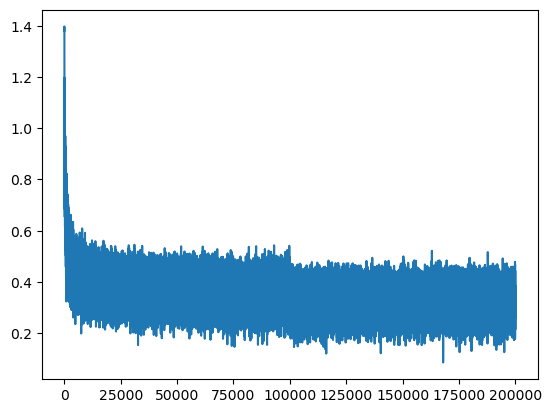

In [9]:
plt.plot(lossi)

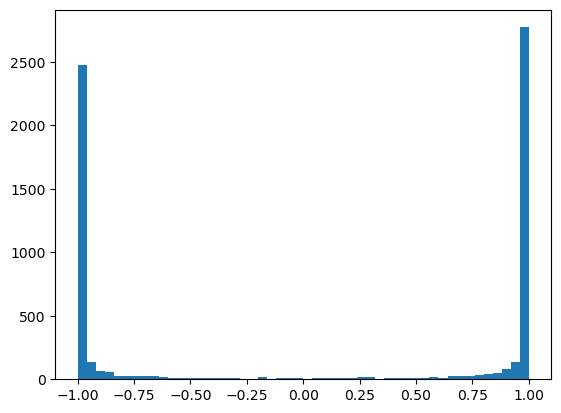

In [10]:
plt.hist(h.view(-1).tolist(), 50);

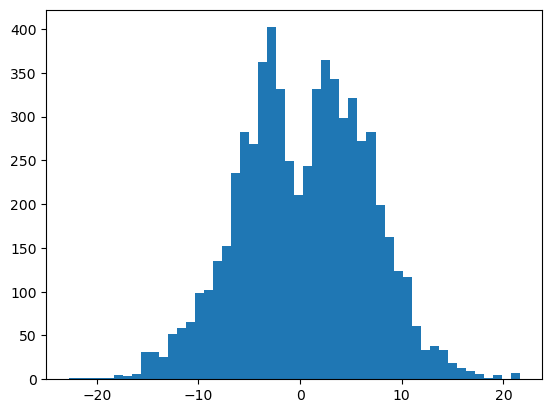

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [9]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':   (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print (split, loss.item())


split_loss('val')
split_loss('train')

val 2.1684703826904297
train 2.1256532669067383


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        print (logits.shape)
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        break
        if ix == 0:
            break

    # print (''.join(itos[i] for i in out))



torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([1, 27])
